In [26]:
from nilearn import plotting, image, masking
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# average functional runs

In [7]:
# merge and average dr outputs
! singularity exec /corral-secure/utdmc/Dell-Medical-Imaging/singularity_images/fsl-6.0.3.simg fslmerge -t Smith09_dmn_group_4d /corral-secure/utdmc/Dell-Medical-Imaging/anibal/devmismatch/preproc/ulg/output/sub-ULG0*/output/pipeline_analysis_nuisance/sub-ULG*_ses-0/dr_tempreg_maps_zstat_files_to_standard_smooth/_scan_REST_run-0*/_selector_CSF-2mmE-M_aC-WM-2mm-DPC5_G-M_M-SDB_P-2/_spatial_map_PNAS_Smith09_rsn10_spatial_map_file_..cpac_templates..PNAS_Smith09_rsn10.nii.gz/_fwhm_4/_dr_tempreg_maps_zstat_files_to_standard_smooth_03/temp_reg_map_z_0003_antswarp_maths.nii.gz
! singularity exec /corral-secure/utdmc/Dell-Medical-Imaging/singularity_images/fsl-6.0.3.simg fslmaths Smith09_dmn_group_4d.nii.gz -Tmean Smith09_dmn_group_4d_mean

In [17]:
# merge and average functional scans
! singularity exec /corral-secure/utdmc/Dell-Medical-Imaging/singularity_images/fsl-6.0.3.simg fslmerge -t func_to_standard_group_4d /corral-secure/utdmc/Dell-Medical-Imaging/anibal/devmismatch/preproc/ulg/output/sub-ULG0*/output/pipeline_analysis_nuisance/sub-ULG*_ses-0/mean_functional_to_standard/_scan_REST_run-*/sub-ULG*_ses-0_task-REST_run-0*_dir-AP_bold_calc_tshift_resample_volreg_calc_tstat_antswarp.nii.gz
! singularity exec /corral-secure/utdmc/Dell-Medical-Imaging/singularity_images/fsl-6.0.3.simg fslmaths func_to_standard_group_4d.nii.gz -Tmean func_to_standard_group_4d_mean


In [33]:
# merge and average t1 scans
! singularity exec /corral-secure/utdmc/Dell-Medical-Imaging/singularity_images/fsl-6.0.3.simg fslmerge -t anat_to_standard_group_4d /corral-secure/utdmc/Dell-Medical-Imaging/anibal/devmismatch/preproc/ulg/output/sub-ULG*/output/pipeline_analysis_nuisance/sub-ULG*_ses-0/anatomical_to_standard/transform_Warped.nii.gz
! singularity exec /corral-secure/utdmc/Dell-Medical-Imaging/singularity_images/fsl-6.0.3.simg fslmaths anat_to_standard_group_4d.nii.gz -Tmean anat_to_standard_group_mean


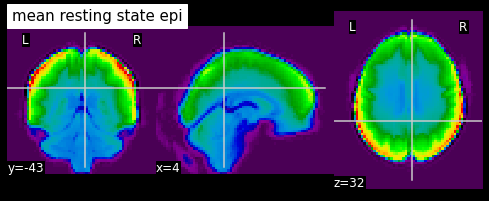

In [24]:
plotting.plot_epi('func_to_standard_group_4d_mean.nii.gz', title = 'mean resting state epi')

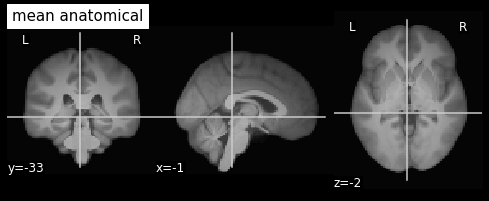

In [25]:
plotting.plot_anat(image.mean_img('anat_to_standard_group_4d.nii.gz'), title = 'mean anatomical')

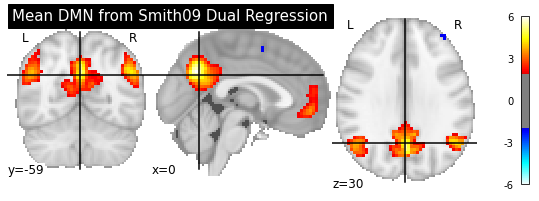

In [23]:
plotting.plot_stat_map('Smith09_dmn_group_4d_mean.nii.gz',
                       threshold=2,
                      title="Mean DMN from Smith09 Dual Regression",).savefig('Smith09_dmn_group_mean.png') 

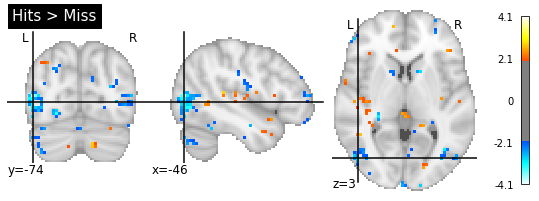

In [32]:
plotting.plot_stat_map('/corral-secure/utdmc/Dell-Medical-Imaging/ULG/BIDS/derivatives/MID/level3/noGSR/Flanker_Cope3_Level3/stats_dir/stats/zstat1.nii.gz',
                       threshold = 2,
                      title = 'Hits > Miss').savefig('mid.png') 

# ROI extraction from Inhibition contrast

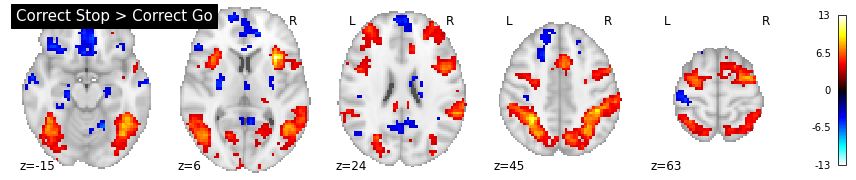

In [22]:
from nilearn.image import threshold_img
tmap = '/corral-secure/utdmc/Dell-Medical-Imaging/ULG/BIDS/derivatives/SST/corrstop_vs_correctgo/level3/noGSR/SST/Cope3_Level3/stats_dir/stats/tstat1_inverted.nii.gz'


threshold_percentile_img = threshold_img(tmap, threshold='97%', copy=False)
# Showing percentile threshold image
plotting.plot_stat_map(threshold_percentile_img, display_mode='z', title = 'Correct Stop > Correct Go', cut_coords=5)


/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


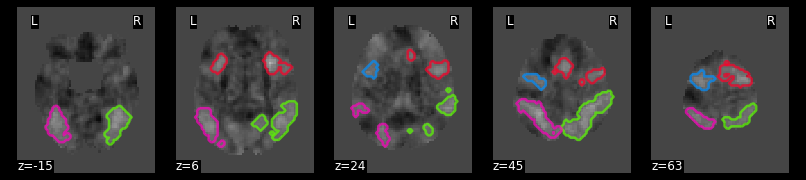

In [10]:
from nilearn.regions import connected_regions

regions_percentile_img, index = connected_regions(threshold_percentile_img,
                                                  min_region_size=1500)

plotting.plot_prob_atlas(regions_percentile_img, bg_img=tmap,
                         view_type='contours', display_mode='z',
                         cut_coords=5)


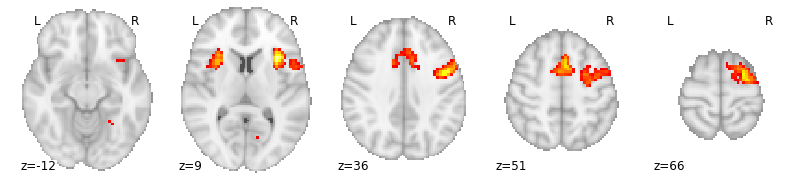

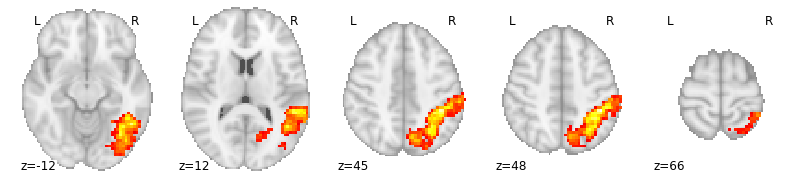

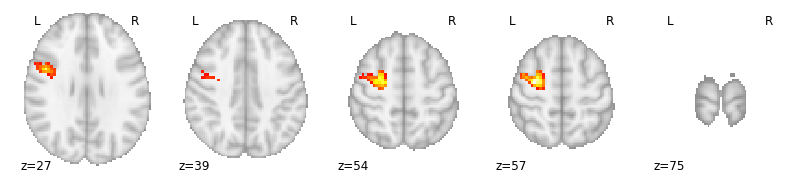

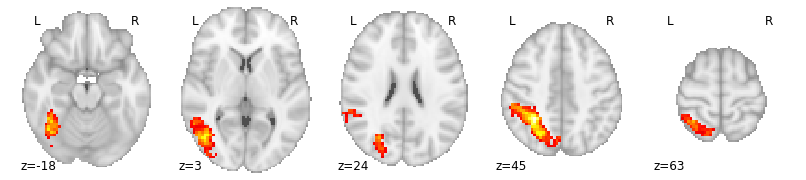

In [14]:
# visualize the connected regions
for img in image.iter_img(regions_percentile_img):

    plotting.plot_stat_map(img, threshold=3, display_mode="z", cut_coords=5,
                           colorbar=False)

In [ ]:
# use ROIs to extract activation values from L1 analysis

In [27]:
# load behavioral measure

ssrt = pd.read_csv('ssrt.csv')
ssrt['SSRT_demeaned'] = ssrt.SSRT - ssrt.SSRT.mean()

ssrt

,participant,run,frameRate,meanSSD,median,SSRT,SSRT_demeaned
0,1,1,60,0.252941,0.536559,283.618204,-3.692167
1,1,2,60,0.278947,0.524916,245.968457,-41.341914
2,10,1,60,0.035484,0.354962,319.478265,32.167895
3,11,1,60,0.208824,0.421033,212.208981,-75.101390
4,11,2,60,0.193750,0.425839,232.088562,-55.221808
...,...,...,...,...,...,...,...
67,44,2,60,0.196875,0.427020,230.145227,-57.165143
68,46,1,60,0.146875,0.371433,224.558025,-62.752345
69,46,2,60,0.123333,0.389332,265.998433,-21.311938
70,6,1,60,0.214706,0.486903,272.196669,-15.113702


In [28]:
# correlate run1 vs run2 
ssrt.pivot(index='participant',columns='run', values='SSRT_demeaned')[1].corr(ssrt.pivot(index='participant',columns='run', values='SSRT_demeaned')[2])

0.3041979615603217

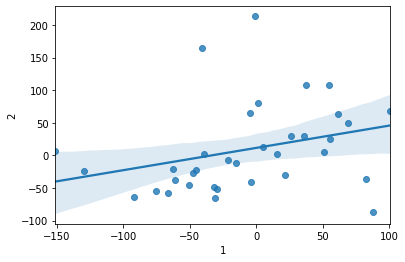

In [29]:
ax = sns.regplot(x = ssrt.pivot(index='participant',columns='run', values='SSRT_demeaned')[1], y = ssrt.pivot(index='participant',columns='run', values='SSRT_demeaned')[2])


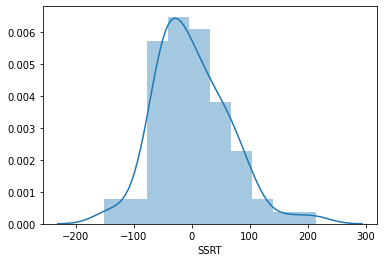

In [30]:
sns.distplot(ssrt.SSRT - ssrt.SSRT.mean())